## A physiologically grounded model of pulmonary acinus for translational research

This notebook provides a python based implementation of the pulmonary acinus model. The notebook implements the metrics dicussed in the paper and also generates the Figures.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from copy import deepcopy
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Configure plotting style for publications
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'mathtext.fontset': 'stix'
})

Global Constants

In [36]:
N = 5  # Number of acinar compartments
ATM_PRESSURE_PA = 101325              # Atmospheric pressure [Pa]
WATER_VAPOR_PRESSURE_PA = 6300        # Water vapor pressure in lungs [Pa]
MMHG_TO_PA = 133.322                  # Conversion from mmHg to Pa
PA_TO_MMHG = 1 / MMHG_TO_PA           # Conversion from Pa to mmHg
P50_PA = 2666                         # O2 partial pressure at 50% Hb saturation [Pa]
H_CAP = 0.2                           # Effective hemoglobin capacity [mol/L]
ALPHA_O2 = 1.39e-3                    # O2 solubility in plasma [mol/(L·Pa)]
ALPHA_CO2 = 0.0307                    # CO2 solubility in plasma [mol/(L·Pa)]

Utility Functions

In [37]:
def hemoglobin_saturation(pO2_Pa: float, P50: float = P50_PA, n: float = 2.7) -> float:
    """Calculate Hb-O2 saturation using Hill equation.
    
    Args:
        pO2_Pa: Oxygen partial pressure [Pa]
        P50: O2 partial pressure at 50% saturation [Pa]
        n: Hill coefficient
        
    Returns:
        Hemoglobin saturation fraction [0-1]
    """
    return (pO2_Pa**n) / (P50**n + pO2_Pa**n)

def d_hemoglobin_saturation_dp(pO2_Pa: float, P50: float = P50_PA, n: float = 2.7) -> float:
    """Calculate derivative of hemoglobin saturation curve w.r.t. pO2.
    
    Args:
        pO2_Pa: Oxygen partial pressure [Pa]
        P50: O2 partial pressure at 50% saturation [Pa]
        n: Hill coefficient
        
    Returns:
        Derivative of saturation curve [Pa^-1]
    """
    if pO2_Pa <= 0.0:
        return 0.0
    term1 = n * (pO2_Pa**(n - 1)) * (P50**n)
    term2 = (P50**n + pO2_Pa**n)**2
    return term1 / term2

def blood_flow_distribution(pO2_arr: np.ndarray, Q_total_blood: float, 
                           P50: float = P50_PA, n: float = 2.0) -> np.ndarray:
    """Distribute blood flow based on local alveolar pO2.
    
    Args:
        pO2_arr: Array of alveolar O2 partial pressures [Pa]
        Q_total_blood: Total perfusion rate [m³/s]
        P50: O2 partial pressure at 50% saturation [Pa]
        n: Exponent for flow distribution
        
    Returns:
        Array of compartmental blood flows [m³/s]
    """
    weights = 1 / (1 + (P50 / np.maximum(1e-6, pO2_arr))**n)
    return weights / np.sum(weights) * Q_total_blood

def breathing_waveform(t: float, freq: float, tidal_vol: float, inhale_frac: float = 0.4) -> float:
    """Compute instantaneous airflow using sinusoidal breathing model.
    
    Args:
        t: Current time [s]
        freq: Breathing frequency [Hz]
        tidal_vol: Tidal volume [m³]
        inhale_frac: Fraction of cycle dedicated to inhalation
        
    Returns:
        Instantaneous airflow [m³/s]
    """
    if freq <= 0 or tidal_vol <= 0:
        return 0.0    
    cycle_dur = 1 / freq
    t_mod = t % cycle_dur
    t_in = inhale_frac * cycle_dur
    t_ex = (1 - inhale_frac) * cycle_dur

    if t_mod < t_in:
        # Inhalation phase
        phase = (t_mod / t_in) * np.pi
        return (np.pi * tidal_vol * freq / inhale_frac) * np.sin(phase)
    else:
        # Exhalation phase
        phase = ((t_mod - t_in) / t_ex) * np.pi
        return -(np.pi * tidal_vol * freq / (1 - inhale_frac)) * np.sin(phase)

def fraction_to_pO2(fraction: float) -> float:
    """Convert O2 fraction to partial pressure.
    
    Args:
        fraction: O2 fraction [unitless]
        
    Returns:
        Partial pressure [Pa]
    """
    return fraction * (ATM_PRESSURE_PA - WATER_VAPOR_PRESSURE_PA)

def fraction_to_pCO2(fraction: float) -> float:
    """Convert CO2 fraction to partial pressure.
    
    Args:
        fraction: CO2 fraction [unitless]
        
    Returns:
        Partial pressure [Pa]
    """
    return fraction * (ATM_PRESSURE_PA - WATER_VAPOR_PRESSURE_PA)

Model definition

In [38]:
def acinar_circuit_model(t, y, params):
    """Differential equations for gas exchange and ventilation-perfusion dynamics.
    
    State Variables:
        y[0:N]          : n_O2, alveolar O2 moles per compartment [mol]
        y[N:2N]         : n_CO2, alveolar CO2 moles [mol]
        y[2N]           : C_blood_O2, pulmonary blood O2 content [mol/L]
        y[2N+1]         : C_blood_CO2, pulmonary blood CO2 content [mol/L]
        y[2N+2]         : C_sys_O2, systemic blood O2 content [mol/L]
        y[2N+3]         : C_sys_CO2, systemic blood CO2 content [mol/L]
        y[2N+4:2N+4+N]  : V_compartments, alveolar volume [m³]
        
    Args:
        t: Current time [s]
        y: State vector
        params: Model parameters dictionary
        
    Returns:
        Derivative vector
    """
    # Initialize derivatives
    dndt_O2 = np.zeros(N)
    dndt_CO2 = np.zeros(N)
    dVdt = np.zeros(N)

    # Calculate airflow [m^3/s]
    freq = params['breathing_frequency_rest'] * params['exercise_factor']
    tidal_vol = params['tidal_volume_rest'] * params['exercise_factor']
    Q_vent = breathing_waveform(t, freq, tidal_vol)

    # Unpack state variables
    n_O2 = y[:N]
    n_CO2 = y[N:2*N]
    C_blood_O2 = y[2*N]
    C_blood_CO2 = y[2*N+1]
    C_sys_O2 = y[2*N+2]
    C_sys_CO2 = y[2*N+3]
    V_compartments = y[2*N+4:2*N+4+N]

    # Compute partial pressures [Pa]
    # BondGraph: These are the effort variables (e) derived from the state variables (q)
    # BondGraph: of the storage elements, e.g., e = f(q). This is the constitutive law of the C elements.
    C_O2 = n_O2 / np.maximum(V_compartments, 1e-10)
    C_CO2 = n_CO2 / np.maximum(V_compartments, 1e-10)
    P_alv_O2 = C_O2 * (ATM_PRESSURE_PA - WATER_VAPOR_PRESSURE_PA)
    P_alv_CO2 = C_CO2 * (ATM_PRESSURE_PA - WATER_VAPOR_PRESSURE_PA)
    P_blood_O2 = C_blood_O2 * (ATM_PRESSURE_PA - WATER_VAPOR_PRESSURE_PA)
    P_blood_CO2 = C_blood_CO2 * (ATM_PRESSURE_PA - WATER_VAPOR_PRESSURE_PA)

    # Distribute airflow based on obstruction
    obstruction_factor = params.get("obstruction_factor", np.zeros(N))
    weights = (1 - obstruction_factor) / np.sum(1 - obstruction_factor)
    # BondGraph: Flow distribution via Modulated Transformers (MTF) from the main 1-junction.
    Q_i_arr = Q_vent * weights

    # Distribute blood flow based on local alveolar O2
    # BondGraph: Source of Flow, Sf:Q_blood
    Q_blood = params['Q_blood'] * params['exercise_factor']
    # BondGraph: Blood flow distribution via MTF, modulated by P_alv_O2 (a signal from the alveolar 0-junction).
    Q_blood_i = blood_flow_distribution(P_alv_O2, Q_blood)

    # Gas exchange coefficients [mol/(Pa·s)]
    k_ex_O2 = params["k_ex_O2"] * params['drug_effect_factor']
    k_ex_CO2 = params["k_ex_CO2"] * params['drug_effect_factor']

    I_ex_O2_total = 0
    I_ex_CO2_total = 0

    # Process each compartment
    # BondGraph: This block calculates the derivatives for each of the N parallel acinar units.
    for i in range(N):
        # Volume change governed by flow and anatomical limit
        if V_compartments[i] <= params['V0_compartments'][i] and Q_i_arr[i] < 0:
            dVdt[i] = 0
        else:
            #BondGraph: Equation for the storage C:V_i. The flow into C is Q_i_arr.
            dVdt[i] = Q_i_arr[i]

        # Gas exchange conductance
        # BondGraph: This section determine the reaction rate for gas exchange.        
        G_O2 = k_ex_O2[i] * (1 - obstruction_factor[i]) * V_compartments[i] * (Q_blood_i[i]/Q_blood)
        G_CO2 = k_ex_CO2[i] * (1 - obstruction_factor[i]) * V_compartments[i] * (Q_blood_i[i]/Q_blood)

        # Gas exchange flux
        I_ex_O2 = G_O2 * (P_alv_O2[i] - P_blood_O2)
        I_ex_CO2 = G_CO2 * (P_blood_CO2 - P_alv_CO2[i])

        # Ventilatory flux
        # BondGraph: This is the Modulated Source of Flow (MSf) injecting moles into the alveolar C elements.
        if Q_i_arr[i] >= 0:
            I_vent_O2 = Q_i_arr[i] * params['C_in_O2']
            I_vent_CO2 = Q_i_arr[i] * params['C_in_CO2']
        else:
            I_vent_O2 = Q_i_arr[i] * C_O2[i]
            I_vent_CO2 = Q_i_arr[i] * C_CO2[i]

        # Update mole derivatives
        # BondGraph: Summing the flows at the 0-junction for C:n_O2,i and C:n_CO2,i.
        # BondGraph: d(n_O2)/dt = (flow from MSf) - (flow through MR)
        dndt_O2[i] = I_vent_O2 - I_ex_O2
        # BondGraph: d(n_CO2)/dt = (flow from MSf) + (flow through MR)
        dndt_CO2[i] = I_vent_CO2 + I_ex_CO2

        I_ex_O2_total += I_ex_O2
        I_ex_CO2_total += I_ex_CO2

    # Pulmonary blood content dynamics
    # BondGraph: This section defines the dynamics of the pulmonary blood storage.
    dS_dp = d_hemoglobin_saturation_dp(P_blood_O2) # [1/Pa]
    P_atm_eff = ATM_PRESSURE_PA - WATER_VAPOR_PRESSURE_PA # [Pa]
    cap_factor_O2 = params['V_blood_pulm'] * P_atm_eff * (ALPHA_O2 / MMHG_TO_PA + H_CAP * dS_dp)
    cap_factor_CO2 = params['V_blood_pulm'] * ALPHA_CO2 * PA_TO_MMHG * P_atm_eff

    # Blood flow effects
    # BondGraph: Flow from the systemic loop, modeled as another MSf.
    I_blood_O2 = Q_blood * (C_sys_O2 - C_blood_O2)
    I_blood_CO2 = Q_blood * (C_sys_CO2 - C_blood_CO2)

    # BondGraph: Equation for C:C_blood_O2. dC/dt = (Σ flows) / Capacitance.
    # BondGraph: Flows are from all N MR elements and the systemic MSf.
    dCdt_blood_O2 = (I_ex_O2_total + I_blood_O2) / cap_factor_O2
    dCdt_blood_CO2 = (-I_ex_CO2_total + I_blood_CO2) / cap_factor_CO2

    # BondGraph: This section defines the systemic R-C circuit dynamics.
    # Systemic tissue consumption dynamics
    # BondGraph: dC/dt = (e_source - e_capacitor) / (R * C) = (Δe) / τ
    dCdt_sys_O2 = (params['C_blood_O2_init'] - C_sys_O2) / params['tau_sys']
    dCdt_sys_CO2 = (params['C_blood_CO2_init'] - C_sys_CO2) / params['tau_sys']

    # Return concatenated derivative vector
    return np.concatenate([
        dndt_O2, dndt_CO2,
        [dCdt_blood_O2, dCdt_blood_CO2],
        [dCdt_sys_O2, dCdt_sys_CO2],
        dVdt
    ])


Analysis routines

In [39]:
def alveolar_o2_improvement(t, y, N, bronchodilator_time=300, window=30):
    """Calculate alveolar O2 improvement after bronchodilator.
    
    Args:
        t: Time vector
        y: State matrix
        N: Number of compartments
        bronchodilator_time: Time of bronchodilator application [s]
        window: Time window for averaging [s]
        
    Returns:
        improvement_percent: Percent improvement per compartment
        O2_pre: Pre-bronchodilator O2 levels
        O2_post: Post-bronchodilator O2 levels
    """
    O2 = y[:N, :]
    pre_indices = np.where((t >= bronchodilator_time - window) & (t <= bronchodilator_time))[0]
    post_indices = np.where((t >= t[-1] - window) & (t <= t[-1]))[0]

    O2_pre = O2[:, pre_indices].mean(axis=1)
    O2_post = O2[:, post_indices].mean(axis=1)

    improvement_percent = (O2_post - O2_pre) / O2_pre * 100
    return improvement_percent, O2_pre, O2_post

def calculate_o2_exchange_flux(t, y, params, N, bronchodilator_time=300, window=30):
    """Calculate O2 exchange flux before and after intervention.
    
    Args:
        t: Time vector
        y: State matrix
        params: Model parameters
        N: Number of compartments
        bronchodilator_time: Time of intervention [s]
        window: Time window for averaging [s]
        
    Returns:
        mean_flux_pre: Pre-intervention flux [mol/s]
        mean_flux_post: Post-intervention flux [mol/s]
        percent_change: Percent change in flux
    """
    obstruction_factor = params.get('obstruction_factor', np.zeros(N))
    Q_blood = params['Q_blood'] * params['exercise_factor']
    k_ex_O2 = params["k_ex_O2"] * params['drug_effect_factor']

    pre_indices = np.where((t >= bronchodilator_time - window) & (t <= bronchodilator_time))[0]
    post_indices = np.where((t >= t[-1] - window) & (t <= t[-1]))[0]

    fluxes_pre = []
    fluxes_post = []

    for indices, flux_list in [(pre_indices, fluxes_pre), (post_indices, fluxes_post)]:
        for idx in indices:
            y_t = y[:, idx]
            n_O2 = y_t[:N]
            V_compartments = y_t[2*N+4:2*N+4+N]
            C_blood_O2 = y_t[2*N]

            with np.errstate(divide='ignore', invalid='ignore'):
                C_O2 = np.where(V_compartments > 0, n_O2 / V_compartments, 0)

            P_alv_O2 = C_O2 * (ATM_PRESSURE_PA - WATER_VAPOR_PRESSURE_PA)
            P_blood_O2 = C_blood_O2 * (ATM_PRESSURE_PA - WATER_VAPOR_PRESSURE_PA)

            Q_blood_i = blood_flow_distribution(P_alv_O2, Q_blood)
            G_O2 = k_ex_O2 * (1 - obstruction_factor) * V_compartments * (Q_blood_i / Q_blood)
            I_ex_O2 = G_O2 * (P_alv_O2 - P_blood_O2)

            flux_list.append(np.sum(I_ex_O2))

    mean_flux_pre = np.mean(fluxes_pre)
    mean_flux_post = np.mean(fluxes_post)
    percent_change = (mean_flux_post - mean_flux_pre) / mean_flux_pre * 100 if mean_flux_pre != 0 else np.nan

    return mean_flux_pre, mean_flux_post, percent_change

def compute_vaq_stats(VAQ_ratio):
    """Compute statistics of VA/Q ratio distribution.
    
    Args:
        VAQ_ratio: Array of VA/Q ratios
        
    Returns:
        mean_log_vaq: Mean of log10(VA/Q)
        std_log_vaq: Standard deviation of log10(VA/Q)
    """
    log_vaq = np.log10(np.maximum(VAQ_ratio, 1e-6))
    return np.mean(log_vaq, axis=0), np.std(log_vaq, axis=0)

def compute_shunt_deadspace_fractions(VAQ_ratio):
    """Compute shunt and deadspace fractions from VA/Q ratios.
    
    Args:
        VAQ_ratio: Array of VA/Q ratios
        
    Returns:
        shunt_fraction: Fraction of compartments with VA/Q < 0.1
        deadspace_fraction: Fraction of compartments with VA/Q > 10.0
    """
    shunt_mask = VAQ_ratio < 0.1
    deadspace_mask = VAQ_ratio > 10.0
    return np.mean(shunt_mask, axis=0), np.mean(deadspace_mask, axis=0)

def compute_cycle_aware_vaq(Q_i_arr, Q_blood_i_arr, Q_vent, t):
    """Compute VA/Q ratios during inspiration phases only.
    
    Args:
        Q_i_arr: Ventilation per compartment [m³/s] (T, N)
        Q_blood_i_arr: Perfusion per compartment [m³/s] (N, T)
        Q_vent: Total ventilation [m³/s] (T,)
        t: Time vector [s] (T,)
        
    Returns:
        VAQ_cycles: VA/Q per cycle (N, num_cycles)
        insp_start_times: Start times of each inspiration [s]
    """
    dt = np.mean(np.diff(t))
    insp_start_idxs = np.where((Q_vent[:-1] <= 0) & (Q_vent[1:] > 0))[0]

    VAQ_cycles = []
    for i in range(len(insp_start_idxs) - 1):
        start = insp_start_idxs[i]
        end = insp_start_idxs[i + 1]
        duration = (end - start) * dt

        ventilation = np.trapz(Q_i_arr[start:end, :], dx=dt, axis=0)
        perfusion = np.mean(Q_blood_i_arr[:, start:end], axis=1) * duration
        vaq = ventilation / np.maximum(perfusion, 1e-8)
        VAQ_cycles.append(vaq)

    insp_start_times = t[insp_start_idxs[:-1]]
    return np.array(VAQ_cycles).T, insp_start_times


Simulation routines

Asthma

In [40]:
def simulate_asthma(params_base, y0, t_total=600):
    """Simulate asthma with reversible bronchoconstriction and bronchodilator response.
    
    Args:
        params_base: Base model parameters
        y0: Initial state vector
        t_total: Total simulation time [s]
        
    Returns:
        t: Time vector
        O2: Alveolar O2 moles over time
        blood_O2: Blood O2 content over time
    """
    # Phase 1: Bronchoconstriction (0-300s)
    params_asthma = deepcopy(params_base)
    obstruction = np.array([0.0, 0.8, 0.8, 0.0, 0.0])
    params_asthma['obstruction_factor'] = obstruction
    
    sol_constricted = solve_ivp(
        acinar_circuit_model, 
        [0, 300], 
        y0, 
        args=(params_asthma,),
        t_eval=np.linspace(0, 300, 300),
        method='BDF',
        rtol=1e-6,
        atol=1e-8
    )
    
    # Phase 2: Bronchodilator effect (300-600s)
    y0_dilated = sol_constricted.y[:, -1]
    params_dilated = deepcopy(params_asthma)
    params_dilated['obstruction_factor'] = obstruction * 0.25
    
    sol_dilated = solve_ivp(
        acinar_circuit_model, 
        [300, t_total], 
        y0_dilated, 
        args=(params_dilated,),
        t_eval=np.linspace(300, t_total, 300),
        method='BDF',
        rtol=1e-6,
        atol=1e-8
    )
    
    # Combine results
    t = np.concatenate([sol_constricted.t, sol_dilated.t])
    y = np.hstack([sol_constricted.y, sol_dilated.y])
    O2 = np.hstack([sol_constricted.y[:N], sol_dilated.y[:N]])
    blood_O2 = np.hstack([sol_constricted.y[2*N], sol_dilated.y[2*N]])
    
    # Plotting
    plt.figure(figsize=(12, 6), dpi=300)
    plt.subplot(121)
    for i in range(N):
        plt.plot(t, O2[i] * 1e3, label=f'Comp {i+1}')
    plt.axvline(300, color='r', linestyle='--', label='Bronchodilator')
    plt.xlabel('Time (s)', fontsize=12, fontweight='bold')
    plt.ylabel('Alveolar O₂ (mmol)', fontsize=12, fontweight='bold')
    plt.title('Asthma: Alveolar O₂ Response', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    
    plt.subplot(122)
    plt.plot(t, blood_O2 * 1e3)
    plt.axvline(300, color='r', linestyle='--')
    plt.xlabel('Time (s)', fontsize=12, fontweight='bold')
    plt.ylabel('Blood O₂ Content (mmol/L)', fontsize=12, fontweight='bold')
    plt.title('Systemic Oxygenation', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('Bronchodilator_impact.pdf', bbox_inches='tight')
    plt.show()

    # Analysis
    improvement_percent, O2_pre, O2_post = alveolar_o2_improvement(t, y, N)
    print("Alveolar O2 improvement per compartment (%):", improvement_percent)

    mean_flux_pre, mean_flux_post, flux_percent_change = calculate_o2_exchange_flux(t, y, params_base, N)
    print(f"O2 exchange flux pre-bronchodilator: {mean_flux_pre:.3e} mol/s")
    print(f"O2 exchange flux post-bronchodilator: {mean_flux_post:.3e} mol/s")
    print(f"Percent change in O2 exchange flux: {flux_percent_change:.2f}%")

    return t, O2, blood_O2


COPD

In [41]:
def plot_mean_vaq_per_compartment(VAQ_cycles, obstruction_factors, k_ex_O2, volumes):
    """Plot mean log10(VA/Q) per compartment with error bars.
    
    Args:
        VAQ_cycles: VA/Q ratios per cycle (N, num_cycles)
        obstruction_factors: Obstruction levels per compartment
        k_ex_O2: O2 gas exchange conductances
        volumes: Compartment volumes
    """
    log_vaq = np.log10(np.clip(VAQ_cycles, 1e-3, 1e3))
    mean_log_vaq = np.mean(log_vaq, axis=1)
    std_log_vaq = np.std(log_vaq, axis=1)
    N = VAQ_cycles.shape[0]

    # Setup plot
    plt.figure(figsize=(10, 6), dpi=300)
    ax = plt.gca()
    
    # Color mapping for obstruction factor
    cmap = plt.cm.Reds
    norm = mcolors.Normalize(vmin=0, vmax=1)
    colors = cmap(norm(obstruction_factors))
    
    # Plot bars with error bars
    bars = ax.bar(np.arange(N), mean_log_vaq, yerr=std_log_vaq, capsize=6,
                  color=colors, edgecolor='k', alpha=0.8)
    
    # Reference line at V/Q = 1 (log10 = 0)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1.5, label="V/Q = 1")
    
    # Labels and titles
    ax.set_xlabel("Compartment Index", fontsize=14, fontweight='bold')
    ax.set_ylabel(r"Mean $\log_{10}(V_A/Q)$", fontsize=14, fontweight='bold')
    ax.set_xticks(np.arange(N))
    ax.set_xticklabels([f"{i+1}" for i in range(N)], fontsize=12, fontweight='bold')
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Annotate with volume and k_ex_O2
    for i, (bar, vol, kex) in enumerate(zip(bars, volumes, k_ex_O2)):
        ax.text(bar.get_x() + bar.get_width()/2, 0.05,
                f"V={vol:.1e}\nk={kex:.1e}", 
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Colorbar for obstruction
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.01)
    cbar.set_label("Obstruction Factor", fontsize=12, fontweight='bold')
    cbar.ax.tick_params(labelsize=10)
    
    ax.legend(fontsize=12, loc='upper left')
    plt.tight_layout()
    plt.savefig("Figure_2.pdf", bbox_inches='tight')
    plt.show()

def calculate_physiologic_metrics(sol, params, Q_i_arr, Q_blood_i):
    """
    Calculates physiologic shunt and deadspace fractions based on the
    Riley-Cournand three-compartment lung model.

    This method avoids arbitrary V/Q thresholds by using fundamental
    gas mixing equations.

    Parameters:
    - sol: The solution object from solve_ivp.
    - params: The dictionary of model parameters.
    - Q_i_arr: Array of compartmental ventilation flows over time [m^3/s].
    - Q_blood_i: Array of compartmental perfusion flows over time [m^3/s].

    Returns:
    - shunt_fraction: Time series of the physiologic shunt fraction.
    - deadspace_fraction: Time series of the physiologic deadspace fraction.
    """
    # --- Extract necessary variables from the simulation output ---
    N = params.get("obstruction_factor", np.zeros(5)).shape[0]
    
    # Gas concentrations and partial pressures
    n_O2 = sol.y[:N]
    n_CO2 = sol.y[N:2*N]
    V_compartments = sol.y[2*N+4:2*N+4+N]
    
    C_alv_O2 = n_O2 / V_compartments
    C_alv_CO2 = n_CO2 / V_compartments
    P_alv_O2 = C_alv_O2 * (ATM_PRESSURE_PA - WATER_VAPOR_PRESSURE_PA)
    P_alv_CO2 = C_alv_CO2 * (ATM_PRESSURE_PA - WATER_VAPOR_PRESSURE_PA)

    # Blood O2/CO2 contents (mol/L)
    C_arterial_O2 = sol.y[2*N]
    C_arterial_CO2 = sol.y[2*N+1]
    C_mixed_venous_O2 = sol.y[2*N+2]
    C_mixed_venous_CO2 = sol.y[2*N+3]
    
    # Total blood flow
    Q_total_blood = np.sum(Q_blood_i, axis=1)

    # --- 1. Calculate Physiologic Shunt Fraction ---
    # Shunt fraction = (Cc'_O2 - Ca_O2) / (Cc'_O2 - Cv_O2)
    # where Cc'_O2 is the O2 content of blood in the "ideal" compartment.
    
    # Calculate ideal alveolar O2 pressure (perfusion-weighted average)
    P_ideal_alv_O2 = np.sum(P_alv_O2.T * Q_blood_i, axis=1) / Q_total_blood

    # Calculate O2 content of blood equilibrated with ideal alveolar air
    sat_ideal = hemoglobin_saturation(P_ideal_alv_O2)
    C_ideal_capillary_O2 = ALPHA_O2 * P_ideal_alv_O2 + H_CAP * sat_ideal
    
    # Calculate shunt fraction
    shunt_numerator = C_ideal_capillary_O2 - C_arterial_O2
    shunt_denominator = C_ideal_capillary_O2 - C_mixed_venous_O2
    # Avoid division by zero if there's no A-v difference
    shunt_fraction = np.divide(shunt_numerator, shunt_denominator, 
                               out=np.zeros_like(shunt_numerator), 
                               where=shunt_denominator!=0)
    shunt_fraction = np.clip(shunt_fraction, 0, 1) # Ensure physiological bounds

    # --- 2. Calculate Physiologic Deadspace Fraction ---
    # Deadspace fraction = (Pa_CO2 - Pe_CO2) / Pa_CO2
    # where Pe_CO2 is the mixed expired CO2 pressure.

    # Calculate arterial PCO2 from arterial CO2 content
    P_arterial_CO2 = C_arterial_CO2 * (ATM_PRESSURE_PA - WATER_VAPOR_PRESSURE_PA)

    # Calculate mixed expired CO2 concentration
    # This is the flow-weighted average of expired gas from each compartment
    total_expired_flow = np.sum(Q_i_arr, axis=1)
    
    # Consider only exhalation phase (total flow < 0)
    is_exhaling = total_expired_flow < 0
    
    # Molar flow of CO2 from each compartment during exhalation
    expired_co2_molar_flow = C_alv_CO2.T * Q_i_arr
    total_expired_co2_molar_flow = np.sum(expired_co2_molar_flow, axis=1)

    C_mixed_expired_CO2 = np.divide(total_expired_co2_molar_flow, total_expired_flow,
                                    out=np.zeros_like(total_expired_flow),
                                    where=is_exhaling)
    
    P_mixed_expired_CO2 = C_mixed_expired_CO2 * (ATM_PRESSURE_PA - WATER_VAPOR_PRESSURE_PA)

    # Calculate deadspace fraction using the Enghoff modification of the Bohr equation
    deadspace_numerator = P_arterial_CO2 - P_mixed_expired_CO2
    deadspace_denominator = P_arterial_CO2
    deadspace_fraction = np.divide(deadspace_numerator, deadspace_denominator,
                                   out=np.zeros_like(deadspace_numerator),
                                   where=deadspace_denominator!=0)
    deadspace_fraction[~is_exhaling] = 0 # Deadspace is only meaningful during exhalation
    deadspace_fraction = np.clip(deadspace_fraction, 0, 1) # Ensure physiological bounds

    return shunt_fraction, deadspace_fraction



def simulate_copd(base_params, y0_base, t_span=(0, 300)):
    """Simulate COPD with heterogeneous ventilation and impaired diffusion.
    
    Args:
        params_base: Base model parameters
        y0_base: Initial state vector
        t_span: Simulation time range [s]
    """    
    copd_params = deepcopy(base_params)
    copd_params['obstruction_factor'] = np.array([0.2, 0.5, 0.8, 0.1, 0.0])  # Heterogeneous ventilation
    copd_params['k_ex_O2'] = base_params['k_ex_O2'] * np.array([1.0, 0.6, 0.3, 0.9, 1.0])  # Impaired diffusion
    copd_params['k_ex_CO2'] = base_params['k_ex_CO2'] * np.array([1.0, 0.6, 0.3, 0.9, 1.0])
    # Note: The 'volumes' parameter in the paper is V0, the initial/base volume
    copd_params['V0_compartments'] *= np.array([1.0, 1.1, 1.2, 1.0, 0.95])  # Hyperinflation/emphysema
    
    # We need a dense output to accurately calculate flows at each step
    t_eval = np.linspace(*t_span, t_span[1] * 10) # Evaluate at 10 Hz for accuracy

    sol = solve_ivp(
        acinar_circuit_model,
        t_span,
        y0_base,
        args=(copd_params,),
        t_eval=t_eval,
        method='BDF',
        rtol=1e-6,
        atol=1e-8
    )

    # --- Post-processing to calculate flows and metrics ---
    N = len(copd_params['V0_compartments'])
    
    # Recalculate flows based on the solution time steps
    V_compartments = sol.y[2*N+4:2*N+4+N]
    n_O2 = sol.y[:N]
    C_O2 = n_O2 / V_compartments
    P_alv_O2 = C_O2 * (ATM_PRESSURE_PA - WATER_VAPOR_PRESSURE_PA)

    Q_blood = copd_params['Q_blood'] * copd_params['exercise_factor']
    Q_blood_i = blood_flow_distribution(P_alv_O2.T, Q_blood).T # Transpose for correct shape

    freq = copd_params['breathing_frequency_rest'] * copd_params['exercise_factor']
    tidal_vol = copd_params['tidal_volume_rest'] * copd_params['exercise_factor']
    Q_vent_total = np.array([breathing_waveform(t, freq, tidal_vol) for t in sol.t])
    
    weights = (1 - copd_params.get("obstruction_factor", np.zeros(N)))
    weights /= np.sum(weights)
    Q_i_arr = Q_vent_total[:, np.newaxis] * weights
    
    # --- *** NEW METRICS CALCULATION *** ---
    # Replace the old threshold-based method with the new physiological one
    shunt_fraction, deadspace_fraction = calculate_physiologic_metrics(sol, copd_params, Q_i_arr, Q_blood_i.T)

    # It's best to average the metrics over the last few cycles to get a stable value
    breathing_period = 1 / freq
    num_cycles_to_average = 5
    averaging_time_start = sol.t[-1] - (num_cycles_to_average * breathing_period)
    stable_indices = np.where(sol.t >= averaging_time_start)

    stable_shunt = np.mean(shunt_fraction[stable_indices])
    # For deadspace, average only during exhalation phases
    exhaling_stable_indices = np.where((sol.t >= averaging_time_start) & (Q_vent_total < 0))
    stable_deadspace = np.mean(deadspace_fraction[exhaling_stable_indices])

    print(f"Physiologic Shunt Fraction (stable): {stable_shunt:.4f}")
    print(f"Physiologic Deadspace Fraction (stable): {stable_deadspace:.4f}")

    # Assuming compute_cycle_aware_vaq and compute_vaq_stats exist
    VAQ_ratio, cycle_times = compute_cycle_aware_vaq(Q_i_arr, Q_blood_i, Q_vent_total, sol.t)
    mean_log_vaq, std_log_vaq = compute_vaq_stats(VAQ_ratio)
    print(f"Final log(VA/Q) SD: {std_log_vaq[-1]:.4f}")
    plot_mean_vaq_per_compartment(VAQ_ratio, copd_params['obstruction_factor'], copd_params['k_ex_O2'], copd_params['V0_compartments'])


ARDS

In [42]:
def compute_metrics(sol, params):
    """Compute key physiological metrics from simulation results.
    
    Args:
        sol: ODE solution object
        params: Model parameters
        
    Returns:
        metrics: Dictionary of computed metrics
    """
    N = len(params['V0_compartments'])
    time = sol.t
    y = sol.y
    
    # Alveolar pO2 over time per compartment
    P_alv_O2 = []
    for state in y.T:
        V = state[2*N+4:2*N+4+N]
        n_O2 = state[:N]
        C_O2 = n_O2 / V
        pO2 = C_O2 * (ATM_PRESSURE_PA - WATER_VAPOR_PRESSURE_PA)
        P_alv_O2.append(pO2)
    P_alv_O2 = np.array(P_alv_O2)  # shape (time, N)

    # Mean alveolar pO2 per compartment
    mean_P_alv_O2 = np.mean(P_alv_O2, axis=0)
    std_P_alv_O2 = np.std(P_alv_O2, axis=0)
    
    # Mean blood O2 content (pulmonary blood capacitor)
    mean_C_blood_O2 = np.mean(y[2*N, :])

    # Mean blood O2 partial pressure
    mean_P_blood_O2 = mean_C_blood_O2 * (ATM_PRESSURE_PA - WATER_VAPOR_PRESSURE_PA)

    # Mean alveolar pO2 overall (average over compartments and time)
    mean_pO2_alv_total = np.mean(P_alv_O2)

    # Oxygen Extraction Ratio
    oxy_extraction_ratio = (mean_pO2_alv_total - mean_P_blood_O2) / mean_pO2_alv_total

    # Alveolar volumes over time per compartment
    V = y[2*N+4:2*N+4+N, :]
    mean_V = np.mean(V, axis=1)
    std_V = np.std(V, axis=1)
    CV_V = std_V / mean_V

    # Shunt fraction approximation
    obstruction_factor = params.get('obstruction_factor', np.zeros(N))
    # Approximate blood flow distribution at mean alveolar pO2
    mean_P_alv_O2_comp = mean_P_alv_O2
    Q_blood_total = params['Q_blood'] * params['exercise_factor']
    Q_blood_i = blood_flow_distribution(mean_P_alv_O2_comp, Q_blood_total)

    shunt_fraction = np.sum(Q_blood_i[obstruction_factor > 0.5]) / np.sum(Q_blood_i)

    return {
        'mean_alveolar_pO2_per_compartment_Pa': mean_P_alv_O2,
        'std_alveolar_pO2_per_compartment_Pa': std_P_alv_O2,
        'mean_blood_O2_content_mol_per_L': mean_C_blood_O2,
        'oxygen_extraction_ratio': oxy_extraction_ratio,
        'alveolar_volume_CV': CV_V,
        'shunt_fraction': shunt_fraction
    }

def plot_ards_summary(metrics, params):
    """Generate publication-quality summary plot for ARDS simulation.
    
    Args:
        metrics: Computed metrics dictionary
        params: Model parameters
    """
    N = len(params['V0_compartments'])

    mean_pO2 = metrics['mean_alveolar_pO2_per_compartment_Pa']
    std_pO2 = metrics['std_alveolar_pO2_per_compartment_Pa']

    cv_vol = metrics['alveolar_volume_CV']
    obstruction = params.get('obstruction_factor', np.zeros(N))
    compartments = np.arange(1, N + 1)

    fig, ax1 = plt.subplots(figsize=(12, 7))
    width = 0.4

    # Normalize obstruction for color mapping
    norm_obs = mcolors.Normalize(vmin=0, vmax=max(np.max(obstruction), 1))
    cmap_obs = cm.Reds
    colors_obs = cmap_obs(norm_obs(obstruction))

    # Bar plot for mean alveolar pO2
    bars1 = ax1.bar(compartments - width / 2, mean_pO2 / 1000, width,
                    yerr=std_pO2 / 1000, capsize=5, color=colors_obs,
                    edgecolor='black', label=r'$\overline{P_{A,O_2}}$')

    ax1.set_xlabel('Compartment', fontsize=12, fontweight='bold')
    ax1.set_ylabel(r'Mean Alveolar $P_{A,O_2}$ (kPa)', fontsize=12, fontweight='bold')
    #ax1.set_title('ARDS Simulation: Alveolar Oxygen and Volume Variability',fontsize=14, fontweight='bold')
    ax1.set_xticks(compartments)
    ax1.set_xticklabels(compartments, fontweight='bold')
    ax1.tick_params(axis='both', labelsize=12)

    # Twin axis for Alveolar Volume CV
    ax2 = ax1.twinx()
    bars2 = ax2.bar(compartments + width / 2, cv_vol, width,
                    color='steelblue', edgecolor='black', alpha=0.8,
                    label=r'$V_A$ CV')
    #Alveolar volume coefficient of variation (CV) as a proxy for heterogeneity/collapse
    ax2.set_ylabel('Alveolar Volume Coefficient of Variation (CV)', fontsize=12, fontweight='bold')
    ax2.tick_params(axis='y', labelsize=12)

    # Add CV text above bars
    for i, val in enumerate(cv_vol):
        ax2.text(compartments[i] + width / 2, val - 0.025, f'{val:.2f}',
                 ha='center', va='bottom', fontsize=11, fontweight='bold', color='black')

    # Legend inside the plot
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    #legend = ax1.legend(h1 + h2, l1 + l2, loc='upper right', fontsize=12, frameon=False,ncols=2)
    ax1.legend(h1 + h2, l1 + l2,loc='upper right', fontsize=12, frameon=False,bbox_to_anchor=(0.82, 1.02))
    # Add only one colorbar (for obstruction)
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.92, 0.25, 0.025, 0.5])  # [left, bottom, width, height]
    sm = cm.ScalarMappable(cmap=cmap_obs, norm=norm_obs)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Obstruction Factor', fontsize=12, fontweight='bold')
    cbar.ax.tick_params(labelsize=12)
    ytick_labels = ax1.get_yticklabels()
    # Iterate through the labels and set their fontweight to 'bold'
    for label in ytick_labels:
        label.set_fontweight('bold')
    ytick_labels = ax2.get_yticklabels()
    # Iterate through the labels and set their fontweight to 'bold'
    for label in ytick_labels:
        label.set_fontweight('bold')

    plt.savefig("Figure_3.pdf",dpi=600)
    plt.show()

def simulate_ards(params_base, y0, t_span=(0, 300)):
    """Simulate ARDS with diffuse injury and impaired gas exchange.
    
    Args:
        params_base: Base model parameters
        y0: Initial state vector
        t_span: Simulation time range [s]
    """
    params_ards = deepcopy(params_base)
    params_ards['obstruction_factor'] = np.array([0, 0.8, 0, 0.9, 0])
    params_ards['k_ex_O2'] *= 0.3
    params_ards['k_ex_CO2'] *= 0.3
    params_ards['tidal_volume_rest'] *= 0.7
    params_ards['breathing_frequency_rest'] *= 0.9
    
    sol = solve_ivp(
        acinar_circuit_model, 
        t_span, 
        y0, 
        args=(params_ards,),
        t_eval=np.linspace(*t_span, 300),
        method='BDF',
        rtol=1e-6,
        atol=1e-8
    )
    
    # Compute and plot metrics
    metrics = compute_metrics(sol, params_ards)
    plot_ards_summary(metrics, params_ards)
    return sol.t, sol.y[:N]


Base model parameters

In [43]:
base_params = {
    'breathing_frequency_rest': 0.2,
    'tidal_volume_rest': 0.0004,
    'C_in_O2': 0.21,
    'C_in_CO2': 0.0004,
    'C_blood_O2_init': 0.07,
    'C_blood_CO2_init': 0.052,
    'C_alv_O2_init': np.full(N, 0.15),
    'C_alv_CO2_init': np.full(N, 0.08),
    'V0_compartments': np.full(N, 0.000124),
    'k_ex_O2': np.full(N, 3e-10),
    'k_ex_CO2': np.full(N, 5e-9),
    'V_blood_pulm': 5e-5,
    'tau_sys': 60.0,
    'exercise_factor': 1.0,
    'drug_effect_factor': 1.0,
    'obstruction_factor': np.zeros(N),
    'Q_blood': 8.3e-5,
    'simulation_time': 300
}

Setup initial values

In [44]:
n_O2_0 = base_params['C_alv_O2_init'] * base_params['V0_compartments'] #Get the number of moles from volume and concentration specs
n_CO2_0 = base_params['C_alv_CO2_init'] * base_params['V0_compartments'] #Get the number of moles from volume and concentration specs
y0_base = np.concatenate([
    n_O2_0, n_CO2_0,
    [base_params['C_blood_O2_init'], base_params['C_blood_CO2_init']],
    [base_params['C_blood_O2_init'], base_params['C_blood_CO2_init']],
    base_params['V0_compartments']
])

Simulate Asthma

In [45]:
simulate_asthma(base_params, y0_base)
pass

Alveolar O2 improvement per compartment (%): [-10.65886567  32.50817144  32.50817144 -10.65886567 -10.65886567]
O2 exchange flux pre-bronchodilator: 8.068e-10 mol/s
O2 exchange flux post-bronchodilator: 8.221e-10 mol/s
Percent change in O2 exchange flux: 1.89%


Simulate COPD

Physiologic Shunt Fraction (stable): 1.0000
Physiologic Deadspace Fraction (stable): 0.9919
Final log(VA/Q) SD: 0.2567


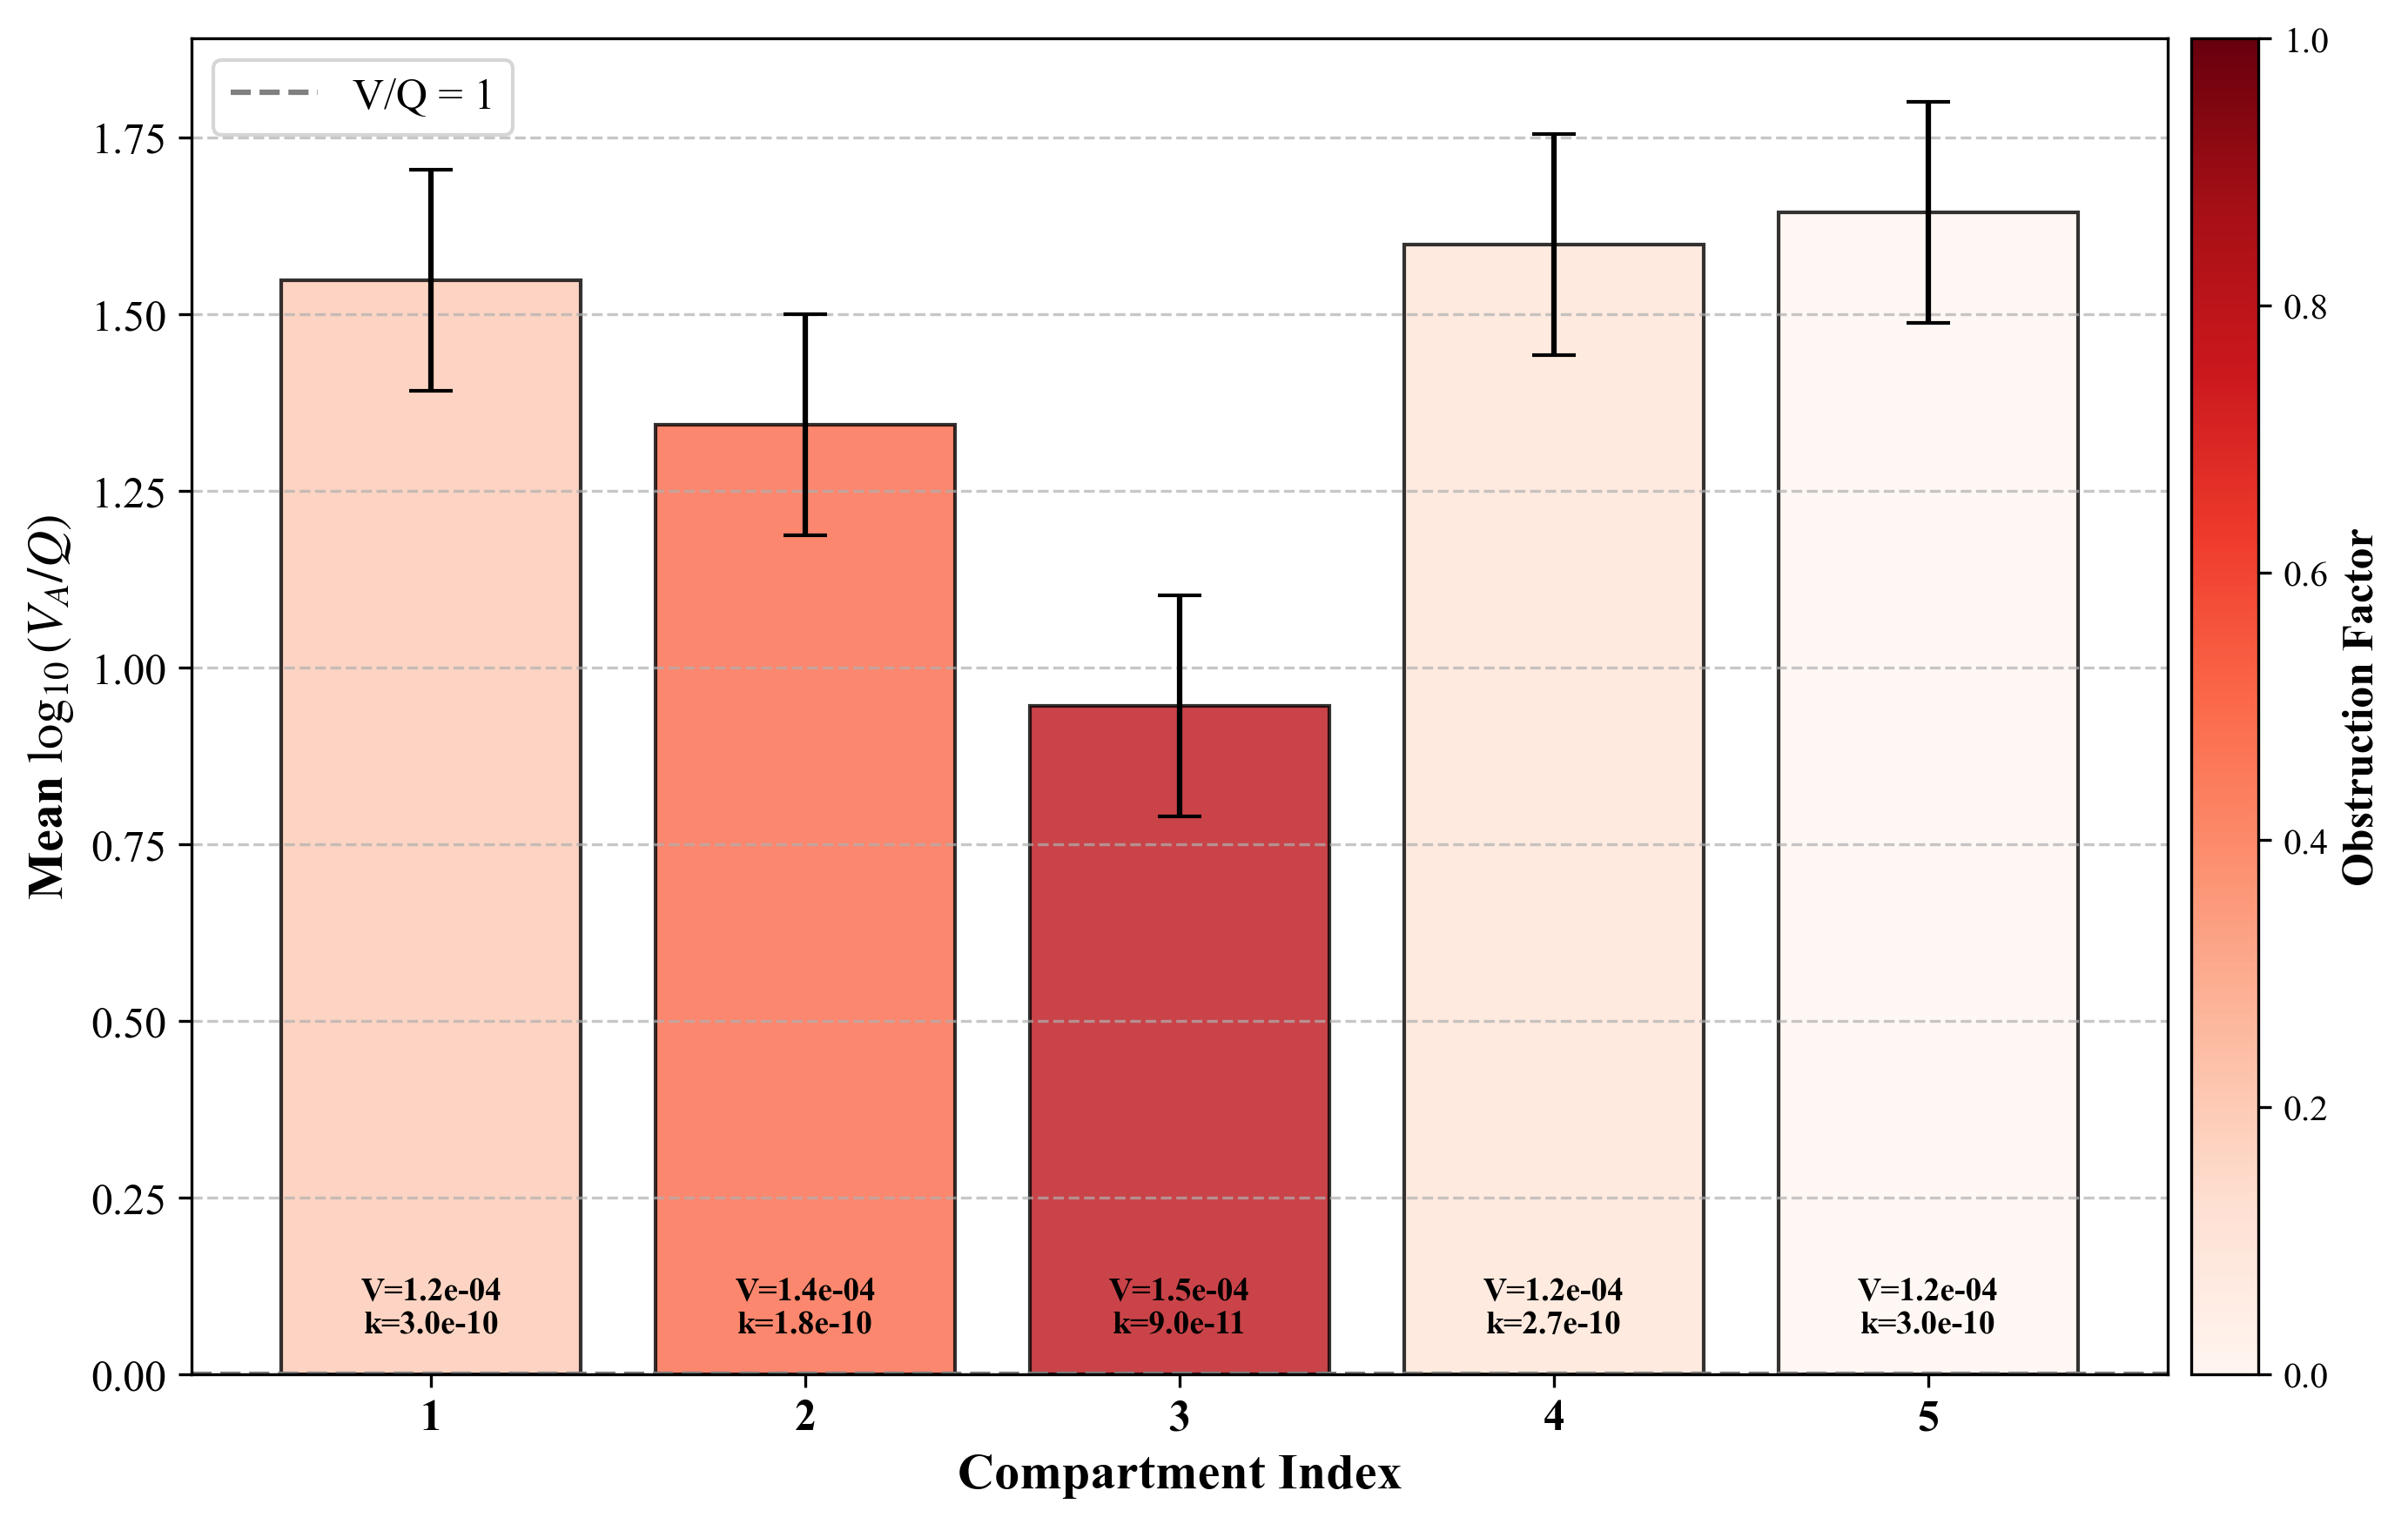

In [46]:
simulate_copd(base_params, y0_base)
pass

Simulate ARDS

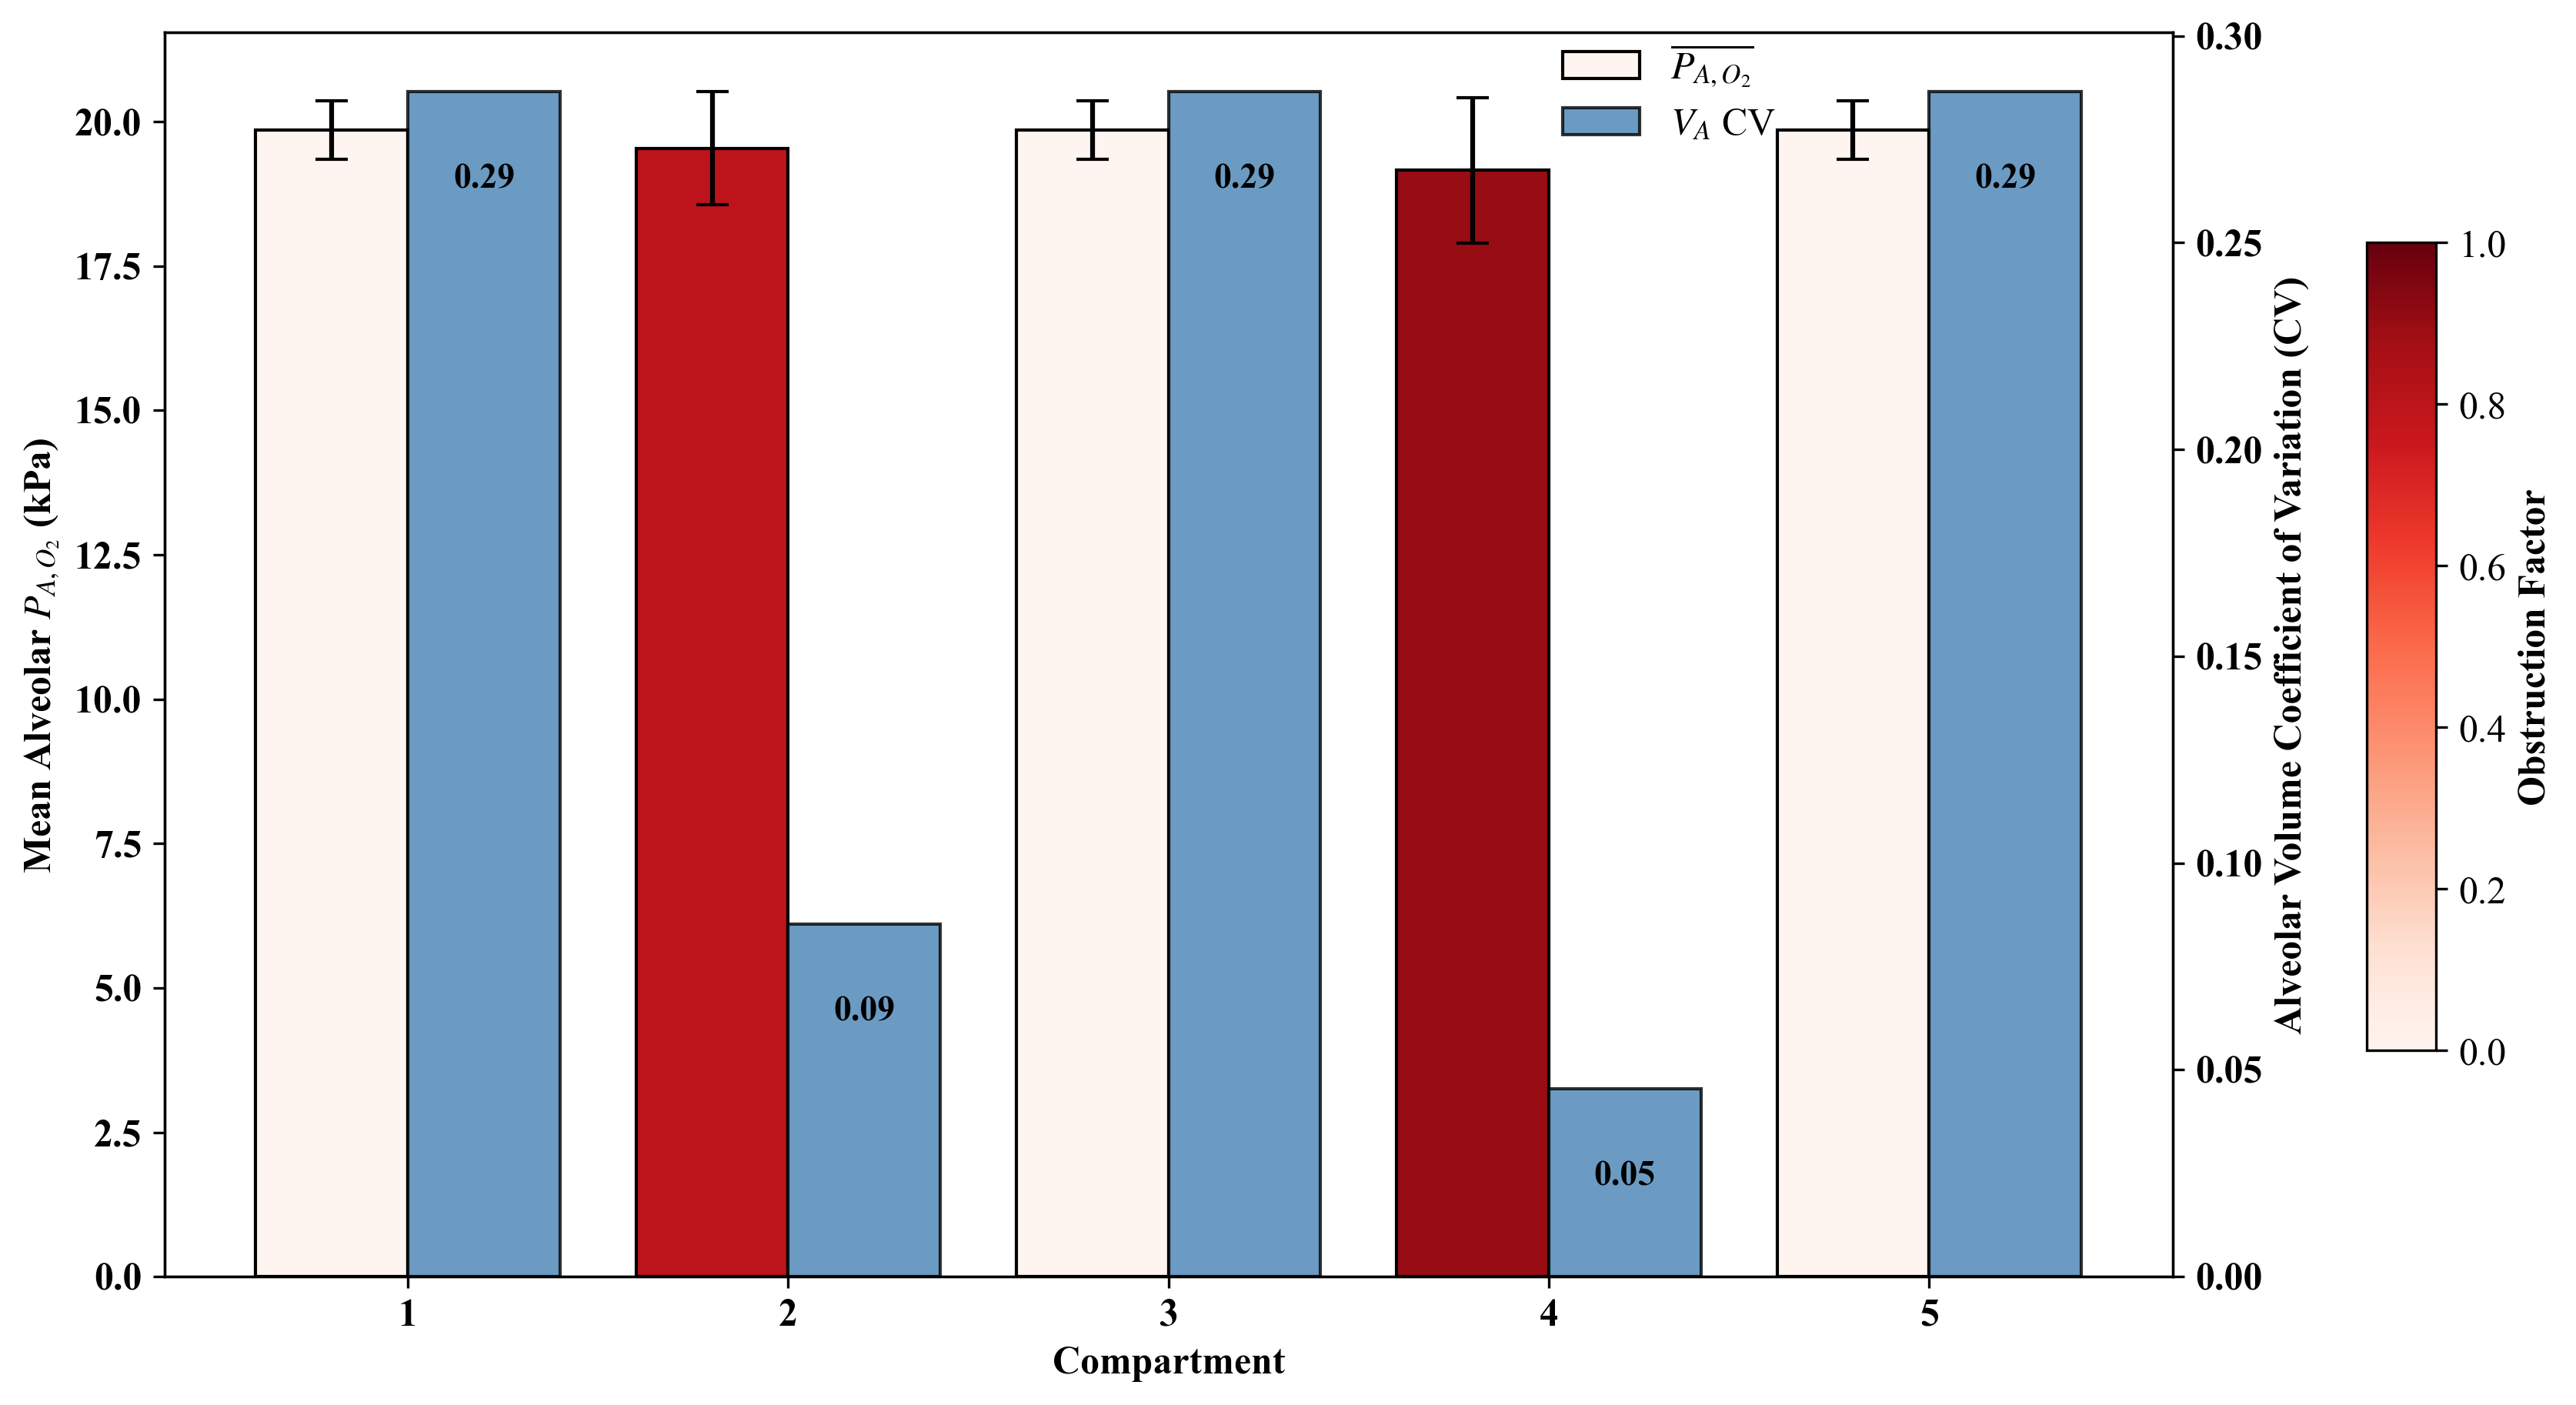

In [47]:
simulate_ards(base_params, y0_base)
pass